In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import joblib
from imageio.v3 import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils
import pywt
from numpy import asarray
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/PR dataset/HAM10000_metadata.csv')

In [ ]:
label_encoder = LabelEncoder()
metadata['dx_label'] = label_encoder.fit_transform(metadata['dx'])

In [ ]:
original_class_counts = np.bincount(metadata["dx_label"])

ros = RandomOverSampler(sampling_strategy={0: 500, 3: 500, 6: 500}, random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(metadata, metadata["dx_label"])

rus = RandomUnderSampler(sampling_strategy={1: 500, 2: 1000, 4: 1000, 5: 1000}, random_state=42)
metadata, y_train_resampled = rus.fit_resample(X_train_oversampled, y_train_oversampled)

In [ ]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_label
0,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,0
1,HAM_0006002,ISIC_0029915,akiec,histo,50.0,female,face,0
2,HAM_0000549,ISIC_0029360,akiec,histo,70.0,male,upper extremity,0
3,HAM_0000549,ISIC_0026152,akiec,histo,70.0,male,upper extremity,0
4,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,0
...,...,...,...,...,...,...,...,...
4995,HAM_0004542,ISIC_0024402,vasc,consensus,0.0,female,back,6
4996,HAM_0001537,ISIC_0026467,vasc,consensus,55.0,male,lower extremity,6
4997,HAM_0004455,ISIC_0030882,vasc,histo,20.0,male,trunk,6
4998,HAM_0003862,ISIC_0033031,vasc,histo,45.0,male,upper extremity,6


In [ ]:
def  image_segmentaion(img):

    img = img.reshape((-1,3))
    img = np.float32(img)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(img,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    colors = np.concatenate((center[0],center[1]),axis=None)

    col = 0 if np.mean(center[0]) > np.mean(center[1]) else 1
    res = center[label.flatten()]
    mask = res.reshape((image.shape))
    for i in range(len(mask)):
      for j in range(len(mask[i])):
        if mask[i][j][0] == center[col][0] and mask[i][j][1] == center[col][1] and mask[i][j][2] == center[col][2]: mask[i][j] = [0, 0, 0]
        else: mask[i][j] = [1, 1, 1]

    edges = cv2.Canny(mask,100,200)
    image = np.multiply(mask,image)

    return image,colors,edges

In [ ]:
def gaborfilter(img):

    ksize = 15
    sigma = 5
    theta = 1*np.pi/2
    lamda = 1*np.pi/4
    gamma=0.9
    phi = 0.8

    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

    return fimg

In [ ]:
def wavelet_transform(img):
  LL, (image, HL, HH) = pywt.dwt2(image, 'bior1.3')
  return image

In [ ]:
class_labels= {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
class DatasetLoader(Dataset):

    def __init__(self,root_dir,mode):
        self.metadata = metadata
        self.root_dir = root_dir
        self.mode = mode

    def __len__(self):
        print(metadata)
        return len(self.metadata)

    def __getitem__(self,i):

        if torch.is_tensor(i):
            i = i.tolist()
        disease = self.metadata.iloc[i,7]
        img_name = os.path.join(self.root_dir,
                                f"{self.metadata.iloc[i, 1]}.jpg")
        image = Image.open(img_name)
        image = asarray(image)
        if self.mode==4:
          sample = {'Image': image,'disease': disease.astype(float)}
          return sample
        image,colors,edges = image_segmentaion(image)
        if self.mode==0:
          features = gaborfilter(image)
        if self.mode==1:
           features = wavelet_transform(image)
        if self.mode==2:
           features = edges

        sample = {'features': features.flatten(), 'color' : colors, 'disease': disease.astype(float)}
        return sample

In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=4)

In [ ]:
i=0
dataX=[]
datay=[]
for X in dataset:
  i+=1
  # print(X["features"].shape)
  dataX.append(X['Image'])
  datay.append(X['disease'])
  if i%1000==0:
    print(f'{i} samples read')

1000 samples read
2000 samples read
3000 samples read
4000 samples read
5000 samples read


In [ ]:
dataX[0].shape

(45, 60, 3)

In [ ]:
pd.Series(datay).value_counts()

2.0    1000
4.0    1000
5.0    1000
0.0     500
1.0     500
3.0     500
6.0     500
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, random_state=42)

In [ ]:
X_train = asarray(X_train)
y_train = asarray(y_train)

In [ ]:
X_test = asarray(X_test)
y_test = asarray(y_test)

Defining CNN for Comparision

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def cnn_model(input_shape=(45, 60, 3), num_classes=4):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
cnn = cnn_model()
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 43, 58, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 21, 29, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 27, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 9, 13, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 11, 128)        73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 5, 128)        

In [ ]:
cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,verbose=1)

Epoch 1/20
100/100 [==============================] - 14s 136ms/step - loss: 0.7793 - accuracy: 0.7150 - val_loss: 1.2697 - val_accuracy: 0.5700
Epoch 2/20
100/100 [==============================] - 13s 129ms/step - loss: 0.7166 - accuracy: 0.7300 - val_loss: 1.2794 - val_accuracy: 0.5537
Epoch 3/20
100/100 [==============================] - 15s 145ms/step - loss: 0.6440 - accuracy: 0.7522 - val_loss: 1.2102 - val_accuracy: 0.5825
Epoch 4/20
100/100 [==============================] - 15s 149ms/step - loss: 0.5657 - accuracy: 0.7828 - val_loss: 1.2261 - val_accuracy: 0.5863
Epoch 5/20
100/100 [==============================] - 15s 147ms/step - loss: 0.5098 - accuracy: 0.8062 - val_loss: 1.3901 - val_accuracy: 0.6025
Epoch 6/20
100/100 [==============================] - 13s 129ms/step - loss: 0.4412 - accuracy: 0.8419 - val_loss: 1.4093 - val_accuracy: 0.5975
Epoch 7/20
100/100 [==============================] - 13s 130ms/step - loss: 0.4778 - accuracy: 0.8206 - val_loss: 1.3443 - val_ac

In [ ]:
cnn.save('/content/drive/MyDrive/PR dataset/Trained_models/ann_v00.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_predict = cnn.predict(X_test)

32/32 [==============================] - 2s 68ms/step


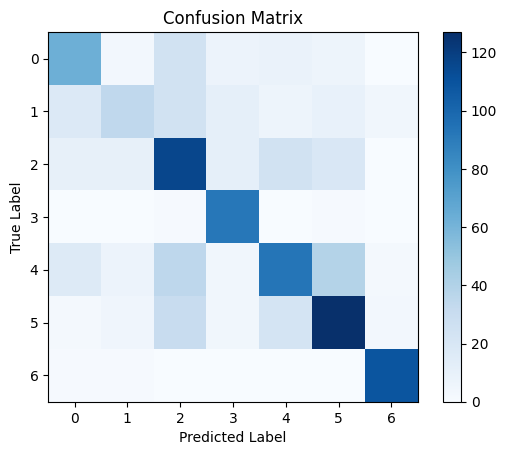

In [ ]:
conf_matrix = confusion_matrix(y_test, np.argmax(y_predict,axis=1))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_test, np.argmax(y_predict,axis=1)))

              precision    recall  f1-score   support

         0.0       0.58      0.57      0.57       111
         1.0       0.57      0.32      0.41       105
         2.0       0.50      0.61      0.55       190
         3.0       0.71      0.98      0.83        94
         4.0       0.61      0.47      0.53       196
         5.0       0.63      0.66      0.64       193
         6.0       0.92      0.98      0.95       111

    accuracy                           0.63      1000
   macro avg       0.65      0.66      0.64      1000
weighted avg       0.63      0.63      0.62      1000



Comparison between Sampling techniques

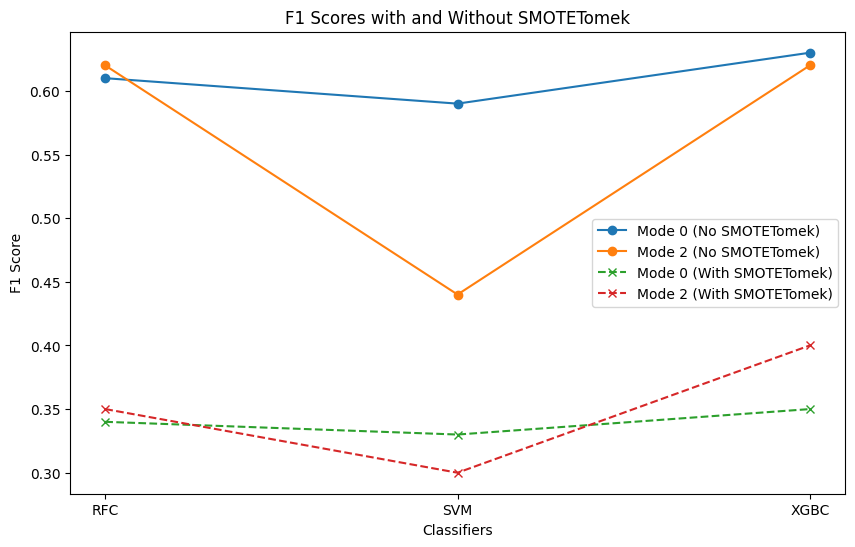

In [2]:
modes = ['Mode 0','Mode 2']
classifiers = ['RFC', 'SVM', 'XGBC']

scores_no_smote = [
    [0.61, 0.59, 0.63],  # Mode 0
    [0.62, 0.44, 0.62]   # Mode 2
]

scores_with_smote = [
    [0.34, 0.33, 0.35],  # Mode 0
    [0.35, 0.30, 0.40]   # Mode 2
]

fig, ax = plt.subplots(figsize=(10, 6))

for i, mode in enumerate(modes):
    ax.plot(classifiers, scores_no_smote[i], marker='o', label=f'{mode} (No SMOTETomek)')

for i, mode in enumerate(modes):
    ax.plot(classifiers, scores_with_smote[i], marker='x', linestyle='dashed', label=f'{mode} (With SMOTETomek)')

ax.set_title('F1 Scores with and Without SMOTETomek')
ax.set_xlabel('Classifiers')
ax.set_ylabel('F1 Score')
ax.legend()

plt.show()
